In [68]:
import numpy as np
from numpy import genfromtxt
from rocketpy import Function
from data import *
from control.matlab import *
from ipywidgets import interact, widgets
plt.style.use('seaborn')

## Calculo de propriedades

In [69]:
class Canard:
    def __init__(self, n, span, rootChord, tipChord, radius, airfoil):
        self.n = n
        self.span = span
        self.rootChord = rootChord
        self.tipChord = tipChord
        self.radius = radius
        self.airfoil = airfoil
        
        self.area = np.pi * radius**2
        self.addFins()
        
        
        # Save geometric parameters for later Fin Flutter Analysis
        self.rootChord = rootChord
        self.tipChord = tipChord
        self.span = span
        #self.distanceRocketFins = distanceToCM
        Cr = self.rootChord
        Ct = self.tipChord
        XFins = ( ((Cr - Ct) / 3) * ((Cr + 2 * Ct) / (Cr + Ct))
                + (1 / 6) * (Cr + Ct - Cr * Ct / (Cr + Ct)))

        self.cpFins= XFins

    def addFins(self):
        
        # Retrieve parameters for calculations
        Af = (self.rootChord + self.tipChord) * self.span / 2  # fin area
        AR = 2 * (self.span ** 2) / Af  # Aspeself.tipChord ratio
        gamac = np.arctan((self.rootChord - self.tipChord) / (2 * self.span))  # mid chord angle
        Cr = self.rootChord
        Ct = self.tipChord
        Yr = self.rootChord + self.tipChord
        s = self.span
        Lf = np.sqrt((self.rootChord / 2 - self.tipChord / 2) ** 2 + self.span ** 2)
        radius = self.radius
        d = 2 * self.radius
        Aref = np.pi * radius**2
        trapezoidalConstant = (
            (Cr + 3 * Ct) * s ** 3
            + 4 * (Cr + 2 * Ct) * radius * s ** 2
            + 6 * (Cr + Ct) * s * radius ** 2
        ) / 12

        # Fin–body interference correction parameters
        tau = (s + radius) / radius
        λ = Ct / Cr
        liftInterferenceFactor = 1 + 1 / tau
        rollForcingInterferenceFactor = (1 / np.pi ** 2) * (
            (np.pi ** 2 / 4) * ((tau + 1) ** 2 / tau ** 2)
            + ((np.pi * (tau ** 2 + 1) ** 2) / (tau ** 2 * (tau - 1) ** 2))
            * np.arcsin((tau ** 2 - 1) / (tau ** 2 + 1))
            - (2 * np.pi * (tau + 1)) / (tau * (tau - 1))
            + ((tau ** 2 + 1) ** 2)
            / (tau ** 2 * (tau - 1) ** 2)
            * (np.arcsin((tau ** 2 - 1) / (tau ** 2 + 1))) ** 2
            - (4 * (tau + 1))
            / (tau * (tau - 1))
            * np.arcsin((tau ** 2 - 1) / (tau ** 2 + 1))
            + (8 / (tau - 1) ** 2) * np.log((tau ** 2 + 1) / (2 * tau))
        )
        rollDampingInterferenceFactor = 1 + (
            ((tau - λ) / (tau)) - ((1 - λ) / (tau - 1)) * np.log(tau)
        ) / (
            ((tau + 1) * (tau - λ)) / (2) - ((1 - λ) * (tau ** 3 - 1)) / (3 * (tau - 1))
        )
        # Auxiliary functions

        # Defines beta parameter
        def beta(mach):
            if mach < 0.8:
                return np.sqrt(1 - mach ** 2)
            elif mach < 1.1:
                return np.sqrt(1 - 0.8 ** 2)
            else:
                return np.sqrt(mach ** 2 - 1)

        # Defines number of fins correction
        def finNumCorrection(n):
            correctorFactor = [2.37, 2.74, 2.99, 3.24]
            if n >= 5 and n <= 8:
                return correctorFactor[n - 5]
            else:
                return n / 2


        clalphaSingleFin = Function(
            lambda mach: 2
            * np.pi
            * AR
            * (Af / Aref)
            / (2 + np.sqrt(4 + ((beta(mach) * AR) / (np.cos(gamac))) ** 2)),
        )

        clalphaMultipleFins = (
            liftInterferenceFactor * finNumCorrection(n) * clalphaSingleFin
        )  # Function of mach number

        # Calculates clalpha * alpha
        cl = Function(
            lambda alpha, mach: alpha * clalphaMultipleFins(mach),
            ["Alpha (rad)", "Mach"],
            "Cl",
        )

        # Save cldata
        self.cl = cl

        # Calculate roll forcing properties
        Ymac = self.radius + self.span / 3 * (self.rootChord + 2 * self.tipChord) / (self.rootChord + self.tipChord)
        clfDelta = (
            rollForcingInterferenceFactor * n * (Ymac + radius) * clalphaSingleFin / d
        ) 

        clfdata = Function(
            lambda delta: clfDelta * delta, "Delta (rad)", "Roll forcing coeficient (Clf)", interpolation="linear"
        )

        # Save clfdata
        self.clfdata = clfdata

        cldOmega =  2 * rollDampingInterferenceFactor * n * clalphaSingleFin * np.cos(cantAngleRad) * trapezoidalConstant / (Aref * d ** 2)
        cldOmegaData = Function(lambda w, v: cldOmega * w * d / (2*v))
        self.cld_data = cldOmegaData

## Definindo aletas e canards

In [70]:
'''Dados do Mini'''
# Dados das aletas
n = 3
span = 0.090
rootChord = 0.090
tipChord = 0.040
airfoil = 'NACA0012 curva Completa.txt'
angulo_maximo_de_abertura = 3 * np.pi / 180

# Dados das canards
n_canard = 2
span_canard = 0.100
rootChord_canard = 0.080
tipChord_canard = 0.080
airfoil_canard = 'NACA0012 curva Completa.txt'
angulo_maximo_de_abertura_canard = 8 * np.pi / 180

# Dados do foguete
radius = 101.6/2000
J = 0.010
Ar = np.pi * radius**2 # Área de referencia
Lr = 2 * radius # Comprimento de referencia

# Dados do ambiente ao redor
rho = 1.06 # air density
velocidade = 0.4 * 343 # Mach 0.5
DynamicPressure = velocidade**2 * rho / 2

# Criando objeto correspondente à aleta
aleta = Canard(n, span, rootChord, tipChord, radius, airfoil)
canard = Canard(n_canard, span_canard, rootChord_canard, tipChord_canard, radius, airfoil)

## Criando as funções de transferência

In [72]:
# Parametros das aletas
forcing_aletas_coef = aleta.clfdata.differentiate(0)
damping_aletas_coef = aleta.cld_data(1, velocidade) - aleta.cld_data(0, velocidade)

# Parametros das canards
forcing_canard_coef = canard.clfdata.differentiate(0)
damping_canard_coef = canard.cld_data(1, velocidade) - canard.cld_data(0, velocidade)

# Parametros intermediarios
P = DynamicPressure * Ar * Lr
C = (damping_aletas_coef + damping_canard_coef)

s = tf([1, 0], 1)

# Planta
Gp = 1 / (J * s + P * C)

# Servo
tau_s = 0.07 / (np.pi/3)
Gs = 1 / (tau_s * s + 1)

# Controlador
Kp = 0.015
I = 7e-3 * 100 * 3
D = 0

print('Kp =', Kp)
print('Ki =', Kp * I)
print('Kd =', Kp * D)

Gc = Kp * (1 + I / s + D * s) # Root Locus do ganho proporcional

# Sensoreamento
H = 1

# Função de transferência total
G = feedback(Gc * Gs * Gp * forcing_canard_coef, H)
print('Ganho da planta = {:.2f} (rad/s) / (N.m)'.format(1 / ((damping_aletas_coef + damping_canard_coef) * DynamicPressure * Ar * Lr)) )
print('Constante de tempo da planta = {:.3f}s'.format(J / ((damping_aletas_coef + damping_canard_coef) * DynamicPressure * Ar * Lr)))
G

Kp = 0.015
Ki = 0.0315
Kd = 0.0
Ganho da planta = 7.27 (rad/s) / (N.m)
Constante de tempo da planta = 0.073s


TransferFunction(array([0.08893, 0.18675]), array([0.00067, 0.01919, 0.22646, 0.18675]))

In [77]:
MaxNormalForce = canard.cldata(8*np.pi/180) * DynamicPressure * Ar

XCgFins = 21/1000

MaxTorque = MaxNormalForce * (XCgFins - canard.cpFins)

print("Applied torque = {:.3f} Nm".format(MaxTorque))
print("Applied torque = {:.3f} kgfcm".format(MaxTorque*10.2))
print("Valores negativos significa que o centro de pressão está acima do centro de massa")

Applied torque = 0.067 Nm
Applied torque = 0.688 kgfcm
Valores negativos significa que o centro de pressão está acima do centro de massa


### Mapa de Polos e Zeros

(array([-13.91177+10.97693j, -13.91177-10.97693j,  -0.88964 +0.j     ]),
 array([-2.1]))

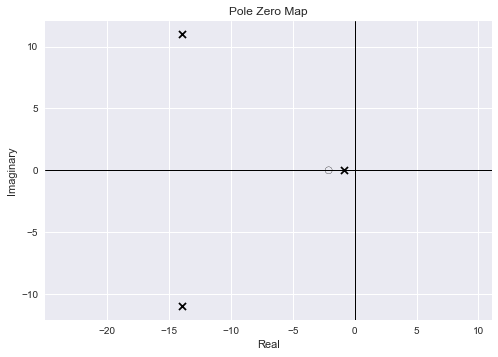

In [ ]:
pzmap(G)

### Resposta à uma entrada impulso

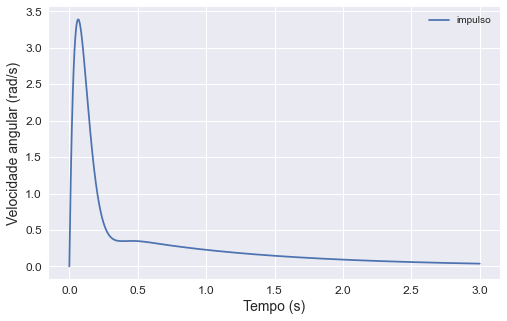

In [ ]:
yi, xi = impulse(G)
fi = Data(xi, yi, 'Tempo (s)', 'Velocidade angular (rad/s)', 'impulso', method='cubicSpline')
fi.plot2D(style='matplotlib', upper=3)

### Resposta à uma entrada degrau

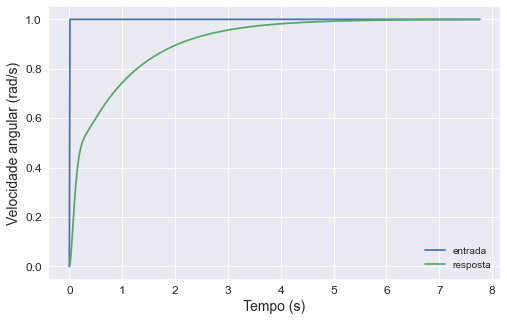

{'RiseTime': 2.0156278364559173,
 'SettlingTime': 3.8723884542749145,
 'SettlingMin': 0.9006401845612256,
 'SettlingMax': 0.9993760285191805,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 0.9993760285191805,
 'PeakTime': 7.764635310879444,
 'SteadyStateValue': 0.9999999999999999}

In [ ]:
# ts = np.linspace(0, 3, 1001)
ys, xs = step(G)
fs = Data(xs, ys, 'Tempo (s)', 'Velocidade angular (rad/s)', 'resposta', method='cubicSpline')
fin = Data(xs, [0 if i == 0 else 1 for i in range(len(xs))], 'Tempo (s)', 'Velocidade angular (rad/s)', 'entrada')
fin.compara2Plots(fs, style='matplotlib')
# fs.plot2D(style='matplotlib')
stepinfo(G)

### Resposta à uma entrada rampa

C:\ProgramData\Anaconda3\lib\site-packages\control\timeresp.py:293: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


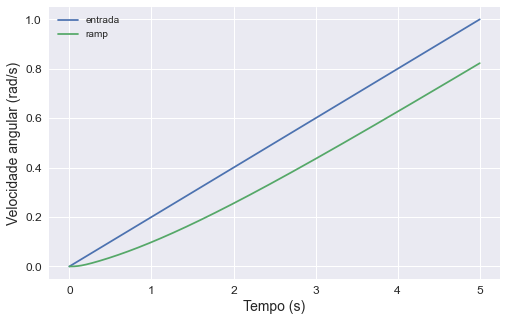

In [ ]:
t = np.linspace(0, 5, 1001)
ramp = np.array([t[i] / max(t) for i in range(len(t))])
yr = lsim(G, ramp, t)[0]
fin = Data(t, ramp, 'Tempo (s)', 'Velocidade angular (rad/s)', 'entrada')
fr = Data(t, yr, 'Tempo (s)', 'Velocidade angular (rad/s)', 'ramp', method='cubicSpline')
fin.compara2Plots(fr, style='matplotlib')

## Bode

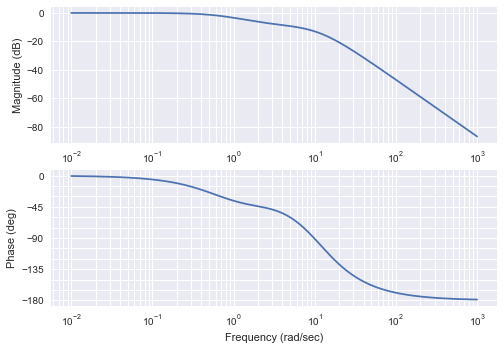

In [ ]:
mag, phase, omega = bode(G)

## Root Locus

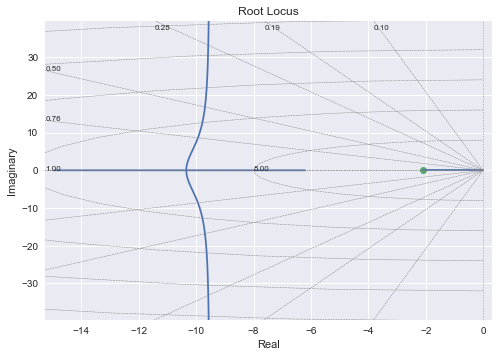

In [ ]:
Gr = Gc * Gs * Gp * forcing_canard_coef / Kp
_ = rlocus(Gr)

## Interact

In [ ]:
def interect_PID(Kp, Ki, Kd):
    s = tf([1, 0], 1)

    # Planta
    Gp = 1 / (J * s + P * C)

    # Servo
    tau_s = 0.07 / (np.pi/3)
    Gs = 1 / (tau_s * s + 1)

    # Controlador
    Gc = Kp + Ki / s + Kd * s

    # Sensoreamento
    H = 1

    # Função de transferência total
    G = feedback(Gc * Gs * Gp * forcing_canard_coef, H)

    # Pzmap
    p, z = pzmap(G)

    # Impulso e Step
    yi, xi = impulse(G)
    ys, xs = step(G)
    
    # Rampa
    t = np.linspace(0, 10, 1001)
    ramp = np.array([t[i] / max(t) for i in range(len(t))])
    yr = lsim(G, ramp, t)[0]

    # Quadrático
    quad = np.array([t[i]**2 / max(t)**2 for i in range(len(t))])
    yq = lsim(G, quad, t)[0]

    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(2*8.09016994375)
    fig.tight_layout()
    axs[0, 0].plot(xi, yi)
    axs[0, 0].set_title('Impulso')
    axs[0, 1].plot(xs, ys)
    axs[0, 1].set_title('Degrau')
    axs[1, 0].plot(t, yr)
    axs[1, 0].set_title('Rampa')
    axs[1, 1].plot(t, yq)
    axs[1, 1].set_title('Quadrado')

    for i in range(2):
        for j in range(1):
            axs[i, j].set(ylabel='Velocidade angular (rad/s)')

    plt.show()

In [ ]:
# interact(interect_PID, Kp=widgets.FloatSlider(min=0, max=1e-2, step=1e-4, readout_format='.4f'), Ki=widgets.FloatSlider(min=0, max=1e-2, step=1e-4, readout_format='.4f'), Kd=widgets.FloatSlider(min=0, max=1e-2, step=1e-4, readout_format='.4f'))